In [30]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor()
)

print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

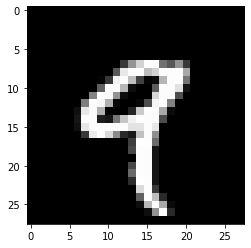

In [32]:
import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(10, 8))
cols, rows = 5, 2
# fig = plt.subplots(rows, cols)
for i in range(rows):
    for j in range(cols):
        img, label = train_data[(i - 1) * cols + j]
        plt.imshow(img.squeeze(), cmap='gray')
        # plt.show()
# plt.tight_layout()
# plt.show()

train_data[0]

In [33]:
from torch.utils.data import DataLoader
loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f8f40690d30>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f8f40690b50>}

In [34]:
from model import LeNet_5, CNN
from torch import optim

model = LeNet_5().to(device)
print(model)
loss_func = nn.CrossEntropyLoss()


LeNet_5(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=480, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (act): Tanh()
)


## Optimizer List

In [35]:
optim_sgd = optim.SGD(model.parameters(), lr=0.1, momentum=0.05) # momentum = ?
# optim_adagrad = optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0.1)
# optim_rms = optim.RMSprop(model.parameters(), centered=True)
# optim_rms2 = optim.RMSprop(model.parameters(), centered=False)
# optim_delta = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06)  # weight_decay=0.1, learning rate should be much larger than other optimizers
# optim_adam = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.005) # there is no weight decay in the training process
# optim_nadam = op.NAdam()

optimizer = optim_sgd

In [36]:
from torch.autograd import Variable
num_epochs = 10

loss_arr_1 = []
loss_arr_2 = []

def train(num_epochs, model, loaders, optimizer, loss_arr):

    model.train()
    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        loss_arr_inside = []
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = images.to(device)   # batch x
            b_y = labels.to(device)   # batch y
            pred = model(b_x)
            # print(pred, b_y)
            loss = loss_func(pred, b_y)
            pred_label = torch.max(pred, 1)[1].data.squeeze()
            # print(pred_label)
            # add loss data to list

            loss_arr_inside.append(loss.detach().numpy())

            # clear gradients for this training step
            optimizer.zero_grad()
            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i + 1) % 100 == 0:
                criterion = sum(loss_arr_inside) / len(loss_arr_inside)
                loss_arr.append(criterion)
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: [{}/{}]'
                       .format(epoch + 1, num_epochs, i + 1, total_step, criterion, (pred_label == labels).sum(), len(pred))) # criterion <=> loss.item()
            pass
        pass
    pass


## RMSprop "Centered" Compare

In [37]:
train(num_epochs, model, loaders, optimizer, loss_arr_1)
print("First Complete")
# train(num_epochs, model, loaders, optim_delta, loss_arr_2)
# print("Second Complete")

Epoch [1/10], Step [100/600], Loss: 2.0511, Accuracy: [73/100]
Epoch [1/10], Step [200/600], Loss: 1.3594, Accuracy: [85/100]
Epoch [1/10], Step [300/600], Loss: 1.0093, Accuracy: [94/100]
Epoch [1/10], Step [400/600], Loss: 0.8098, Accuracy: [97/100]
Epoch [1/10], Step [500/600], Loss: 0.6833, Accuracy: [91/100]
Epoch [1/10], Step [600/600], Loss: 0.5932, Accuracy: [95/100]
Epoch [2/10], Step [100/600], Loss: 0.1129, Accuracy: [96/100]
Epoch [2/10], Step [200/600], Loss: 0.1112, Accuracy: [98/100]
Epoch [2/10], Step [300/600], Loss: 0.1069, Accuracy: [98/100]
Epoch [2/10], Step [400/600], Loss: 0.1015, Accuracy: [98/100]
Epoch [2/10], Step [500/600], Loss: 0.0988, Accuracy: [98/100]
Epoch [2/10], Step [600/600], Loss: 0.0964, Accuracy: [97/100]
Epoch [3/10], Step [100/600], Loss: 0.0647, Accuracy: [96/100]
Epoch [3/10], Step [200/600], Loss: 0.0680, Accuracy: [98/100]
Epoch [3/10], Step [300/600], Loss: 0.0659, Accuracy: [97/100]
Epoch [3/10], Step [400/600], Loss: 0.0636, Accuracy: [

<function matplotlib.pyplot.legend(*args, **kwargs)>

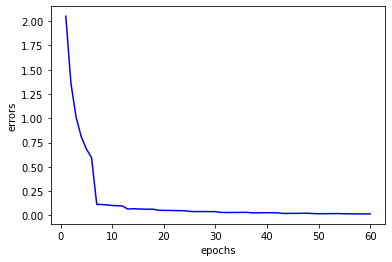

In [38]:
x_range = np.linspace(start=1, stop=60, num=60)
plt.figure()
plt.xlabel('epochs')
plt.ylabel('errors')
plt.plot(x_range, loss_arr_1, color = 'blue')
# plt.plot(x_range, loss_arr_2, color = 'red')
plt.legend

In [39]:
len(loss_arr_1)

60

In [40]:
# for i in enumerate(loss_arr_1):
#     i = i.detach().numpy()
# for i in enumerate(loss_arr_2):
#     i = i.detach().numpy()
# print(loss_arr_1[0].detach().numpy(), type(loss_arr_1[0].detach().numpy))

In [41]:
def test(model):
    # test the model
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            pred = model(images)
            pred_y = torch.max(pred, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            # accuracy = (pred_y ^ labels).sum()
            pass

        print('Test Accuracy of the model on the test images: %.2f' % accuracy)


# test(model)

In [42]:
path = '../model/LeNet_5'

# torch.save(model.state_dict(), path)